In [118]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import os

In [119]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
from services.scenario_service import ScenarioService

In [120]:
test_df = pd.read_csv('test_data/ipc_scenarios.csv')    
test_df.head()

,id,text,sections
0,1,A group of individuals conspire to overthrow t...,"121A, 122"
1,2,A person collects weapons and ammunition with ...,122
2,3,An individual learns about a plot to wage war ...,123
3,4,A group of protestors violently confront the G...,124
4,5,A person publishes inflammatory articles onlin...,124A


In [121]:
bns_df = pd.read_csv('../data/Updated_BNS_Dataset.csv')
bns_df.head()

,Unnamed: 0,Section Number,Chapter Number,Chapter Name,Section Title,Section Description,Vector
0,0,1,1,PRELIMINARY,"Short title, commencement and application.",(1) This Act may be called the Bharatiya Nyaya...,[ 5.10747842e-02 -8.89172684e-03 6.18889229e-...
1,1,2,1,PRELIMINARY,Definitions,"In this Sanhita, unless the context otherwise ...",[ 5.48723862e-02 -7.41926488e-03 -1.08196707e-...
2,2,3,1,PRELIMINARY,General explanations.,(1) Throughout this Sanhita every definition o...,[ 2.37580780e-02 -3.32460217e-02 1.01529686e-...
3,3,4,2,OF PUNISHMENTS,Punishments,The punishments to which offenders are liable ...,[ 3.39037664e-02 -5.81081994e-02 2.61275023e-...
4,4,5,2,OF PUNISHMENTS,Commutation of sentence.,"The appropriate Government may, without the co...",[ 2.01881286e-02 -3.57582755e-02 6.63227960e-...


In [170]:
section_map = bns_df.set_index('Section Number')['Section Description'].to_dict()
print(section_map[191])

(1) Whenever force or violence is used by an unlawful assembly, or by any
member thereof, in prosecution of the common object of such assembly, every member of
such assembly is guilty of the offence of rioting.
(2) Whoever is guilty of rioting, shall be punished with imprisonment of either
description for a term which may extend to two years, or with fine, or with both.
(3) Whoever is guilty of rioting, being armed with a deadly weapon or with anything
which, used as a weapon of offence, is likely to cause death, shall be punished with
imprisonment of either description for a term which may extend to five years, or with fine, or
with both.


In [179]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*contains 0 counts of.*")

def get_bleu_score(reference_text, generated_text):
    reference = [reference_text.split()]
    candidate = generated_text.split()
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

def get_bleu_score_without_smoothing(reference_text, generated_text):
    reference = [reference_text.split()]
    candidate = generated_text.split()
    score = sentence_bleu(reference, candidate)
    return score

In [126]:
ipc_to_bns = {}
with open("test_data/ipc_bns_mapping.csv", mode="r", encoding="utf-8") as f:
    import csv
    reader = csv.DictReader(f)
    for row in reader:
        ipc = row["IPC"].strip()
        bns = row["BNS"].strip()
        ipc_to_bns[ipc] = bns

def dcg_at_k(relevance_scores, k):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k]))

def ndcg_at_k(predicted, ground_truth, k):
    relevance_scores = [1 if sec in ground_truth else 0 for sec in predicted]
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance, k)
    return dcg / idcg if idcg > 0 else 0.0

In [127]:
from scipy.optimize import linear_sum_assignment
def hungarian_algorithm(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return row_ind, col_ind

In [199]:
from tqdm import tqdm

def evaluate_scenarios(service, test_df, top_k=5):
    precision_scores = []
    recall_scores = []
    ndcg_scores = []
    bleu_scores = []

    # Create tqdm progress bar
    pbar = tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", ncols=100, leave=True)

    for _, row in pbar:
        query = row["text"]

        ipc_sections = [s.strip() for s in str(row["sections"]).split(",") if s.strip()]

        bns_mapped_sections = {ipc_to_bns[s] for s in ipc_sections if s in ipc_to_bns}
        ground_truth = bns_mapped_sections

        if not ground_truth:
            continue
        
        top_sections = service.get_top_scenarios(query, history=[], top_k=top_k, validate_with_api=False)
        predicted = [str(sec["Section Number"]) for sec in top_sections if "Section Number" in sec]
        
        if not predicted:
            precision = 0.0
            recall = 0.0
            ndcg = 0.0
            bleu_score = 0.0
        else:
            hits = sum(1 for sec in predicted if sec in ground_truth)
            precision = hits / len(predicted) if predicted else 0.0
            recall = hits / len(ground_truth) if ground_truth else 0.0
            ndcg = ndcg_at_k(predicted, ground_truth, top_k)

            m, n = len(predicted), len(ground_truth)
            scores = np.zeros((m, n))
            ground_truth = list(ground_truth)
            
            for i in range(m):
                for j in range(n):
                    predicted_section_number = int(predicted[i])
                    ground_truth_section_number = int(ground_truth[j])
                    if predicted_section_number not in section_map or ground_truth_section_number not in section_map:
                        continue
                    predicted_description = section_map[predicted_section_number]
                    ground_truth_description = section_map[ground_truth_section_number]
                    scores[i][j] = get_bleu_score(predicted_description, ground_truth_description)

            row_ind, col_ind = hungarian_algorithm(-scores)
            bleu_score = scores[row_ind, col_ind].sum()

        # Append the current scores to the lists
        precision_scores.append(precision)
        recall_scores.append(recall)
        ndcg_scores.append(ndcg)
        bleu_scores.append(bleu_score / min(m, n))

        # Update tqdm's postfix with the current score
        pbar.set_postfix(
            precision=f"{precision:.4f}",
            bleu=f"{bleu_score / min(m, n):.4f}"
        )

    total_evals = len(precision_scores)
    
    if total_evals == 0:
        return {}
    
    results = {
        "Mean Precision@k": round(sum(precision_scores) / total_evals, 4),
        "Mean Recall@k": round(sum(recall_scores) / total_evals, 4),
        "Mean NDCG@k": round(sum(ndcg_scores) / total_evals, 4),
        "Mean BLEU@k": round(sum(bleu_scores) / len(bleu_scores), 4),
    }

    return results

In [137]:
scenario_service = ScenarioService(dataset_path="../data/Updated_BNS_Dataset.csv")

In [177]:
results = evaluate_scenarios(scenario_service, test_df.head(1), top_k=5)
print("Results: ", results)

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

Results:  {'Mean Precision@k': 0.0, 'Mean Recall@k': 0.0, 'Mean NDCG@k': 0.0, 'Mean BLEU@k': np.float64(0.449), 'Mean BLEU@k (without smoothing)': np.float64(0.449)}


In [200]:
all_precisions = []
all_recalls = []
all_mrrs = []
all_bleu_scores = []
all_bleu_scores_without_smoothing = []
k_values = list(range(1, 21))
print("Starting evaluation loop...")
for k_val in k_values:
    results = evaluate_scenarios(scenario_service, test_df, top_k=k_val)
    precision = results['Mean Precision@k']
    recall = results['Mean Recall@k']
    ndcg = results['Mean NDCG@k']
    bleu_score = results['Mean BLEU@k']

    
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_mrrs.append(ndcg)
    all_bleu_scores.append(bleu_score)
    print(f"Results for k={k_val}: ", results)
print("Evaluation loop finished.")

Starting evaluation loop...


Evaluating: 100%|██████████████████| 900/900 [01:25<00:00, 10.59it/s, bleu=0.1113, precision=0.0000]


Results for k=1:  {'Mean Precision@k': 0.3371, 'Mean Recall@k': 0.2657, 'Mean NDCG@k': np.float64(0.3371), 'Mean BLEU@k': np.float64(0.4355)}


Evaluating: 100%|██████████████████| 900/900 [01:28<00:00, 10.13it/s, bleu=0.1113, precision=0.0000]


Results for k=2:  {'Mean Precision@k': 0.2651, 'Mean Recall@k': 0.4055, 'Mean NDCG@k': np.float64(0.4381), 'Mean BLEU@k': np.float64(0.5002)}


Evaluating: 100%|██████████████████| 900/900 [01:30<00:00,  9.97it/s, bleu=0.1113, precision=0.0000]


Results for k=3:  {'Mean Precision@k': 0.2179, 'Mean Recall@k': 0.496, 'Mean NDCG@k': np.float64(0.4844), 'Mean BLEU@k': np.float64(0.5825)}


Evaluating: 100%|██████████████████| 900/900 [01:47<00:00,  8.35it/s, bleu=0.1113, precision=0.0000]


Results for k=4:  {'Mean Precision@k': 0.188, 'Mean Recall@k': 0.5625, 'Mean NDCG@k': np.float64(0.5172), 'Mean BLEU@k': np.float64(0.6434)}


Evaluating: 100%|██████████████████| 900/900 [01:49<00:00,  8.24it/s, bleu=0.1113, precision=0.0000]


Results for k=5:  {'Mean Precision@k': 0.1632, 'Mean Recall@k': 0.6103, 'Mean NDCG@k': np.float64(0.5339), 'Mean BLEU@k': np.float64(0.6857)}


Evaluating: 100%|██████████████████| 900/900 [01:40<00:00,  8.92it/s, bleu=0.1113, precision=0.0000]


Results for k=6:  {'Mean Precision@k': 0.1469, 'Mean Recall@k': 0.6537, 'Mean NDCG@k': np.float64(0.5464), 'Mean BLEU@k': np.float64(0.7223)}


Evaluating: 100%|██████████████████| 900/900 [01:41<00:00,  8.85it/s, bleu=0.1113, precision=0.0000]


Results for k=7:  {'Mean Precision@k': 0.1318, 'Mean Recall@k': 0.6869, 'Mean NDCG@k': np.float64(0.5565), 'Mean BLEU@k': np.float64(0.7511)}


Evaluating: 100%|██████████████████| 900/900 [01:41<00:00,  8.88it/s, bleu=0.1252, precision=0.0000]


Results for k=8:  {'Mean Precision@k': 0.1204, 'Mean Recall@k': 0.7118, 'Mean NDCG@k': np.float64(0.5638), 'Mean BLEU@k': np.float64(0.772)}


Evaluating: 100%|██████████████████| 900/900 [02:09<00:00,  6.97it/s, bleu=0.1252, precision=0.0000]


Results for k=9:  {'Mean Precision@k': 0.1107, 'Mean Recall@k': 0.7333, 'Mean NDCG@k': np.float64(0.5682), 'Mean BLEU@k': np.float64(0.7913)}


Evaluating: 100%|██████████████████| 900/900 [02:10<00:00,  6.92it/s, bleu=0.1252, precision=0.0000]


Results for k=10:  {'Mean Precision@k': 0.1032, 'Mean Recall@k': 0.759, 'Mean NDCG@k': np.float64(0.5733), 'Mean BLEU@k': np.float64(0.8116)}


Evaluating: 100%|██████████████████| 900/900 [02:56<00:00,  5.11it/s, bleu=0.1252, precision=0.0000]


Results for k=11:  {'Mean Precision@k': 0.0965, 'Mean Recall@k': 0.7766, 'Mean NDCG@k': np.float64(0.574), 'Mean BLEU@k': np.float64(0.8258)}


Evaluating: 100%|██████████████████| 900/900 [03:05<00:00,  4.85it/s, bleu=0.1252, precision=0.0000]


Results for k=12:  {'Mean Precision@k': 0.0901, 'Mean Recall@k': 0.789, 'Mean NDCG@k': np.float64(0.5743), 'Mean BLEU@k': np.float64(0.836)}


Evaluating: 100%|██████████████████| 900/900 [03:21<00:00,  4.46it/s, bleu=0.1252, precision=0.0000]


Results for k=13:  {'Mean Precision@k': 0.0847, 'Mean Recall@k': 0.803, 'Mean NDCG@k': np.float64(0.5773), 'Mean BLEU@k': np.float64(0.8471)}


Evaluating: 100%|██████████████████| 900/900 [04:13<00:00,  3.54it/s, bleu=0.1286, precision=0.0000]


Results for k=14:  {'Mean Precision@k': 0.0795, 'Mean Recall@k': 0.8088, 'Mean NDCG@k': np.float64(0.5776), 'Mean BLEU@k': np.float64(0.8527)}


Evaluating: 100%|██████████████████| 900/900 [02:11<00:00,  6.84it/s, bleu=0.1286, precision=0.0000]


Results for k=15:  {'Mean Precision@k': 0.0751, 'Mean Recall@k': 0.8171, 'Mean NDCG@k': np.float64(0.5791), 'Mean BLEU@k': np.float64(0.8597)}


Evaluating: 100%|██████████████████| 900/900 [02:06<00:00,  7.11it/s, bleu=0.1286, precision=0.0000]


Results for k=16:  {'Mean Precision@k': 0.0712, 'Mean Recall@k': 0.8238, 'Mean NDCG@k': np.float64(0.5785), 'Mean BLEU@k': np.float64(0.8658)}


Evaluating: 100%|██████████████████| 900/900 [03:06<00:00,  4.84it/s, bleu=0.1286, precision=0.0000]


Results for k=17:  {'Mean Precision@k': 0.0679, 'Mean Recall@k': 0.8337, 'Mean NDCG@k': np.float64(0.5794), 'Mean BLEU@k': np.float64(0.8727)}


Evaluating: 100%|██████████████████| 900/900 [02:35<00:00,  5.78it/s, bleu=0.1286, precision=0.0000]


Results for k=18:  {'Mean Precision@k': 0.0649, 'Mean Recall@k': 0.8427, 'Mean NDCG@k': np.float64(0.5813), 'Mean BLEU@k': np.float64(0.8795)}


Evaluating: 100%|██████████████████| 900/900 [02:36<00:00,  5.75it/s, bleu=0.1286, precision=0.0000]


Results for k=19:  {'Mean Precision@k': 0.0621, 'Mean Recall@k': 0.8507, 'Mean NDCG@k': np.float64(0.582), 'Mean BLEU@k': np.float64(0.8856)}


Evaluating: 100%|██████████████████| 900/900 [02:23<00:00,  6.25it/s, bleu=0.1286, precision=0.0000]


Results for k=20:  {'Mean Precision@k': 0.0595, 'Mean Recall@k': 0.8573, 'Mean NDCG@k': np.float64(0.583), 'Mean BLEU@k': np.float64(0.891)}
Evaluation loop finished.


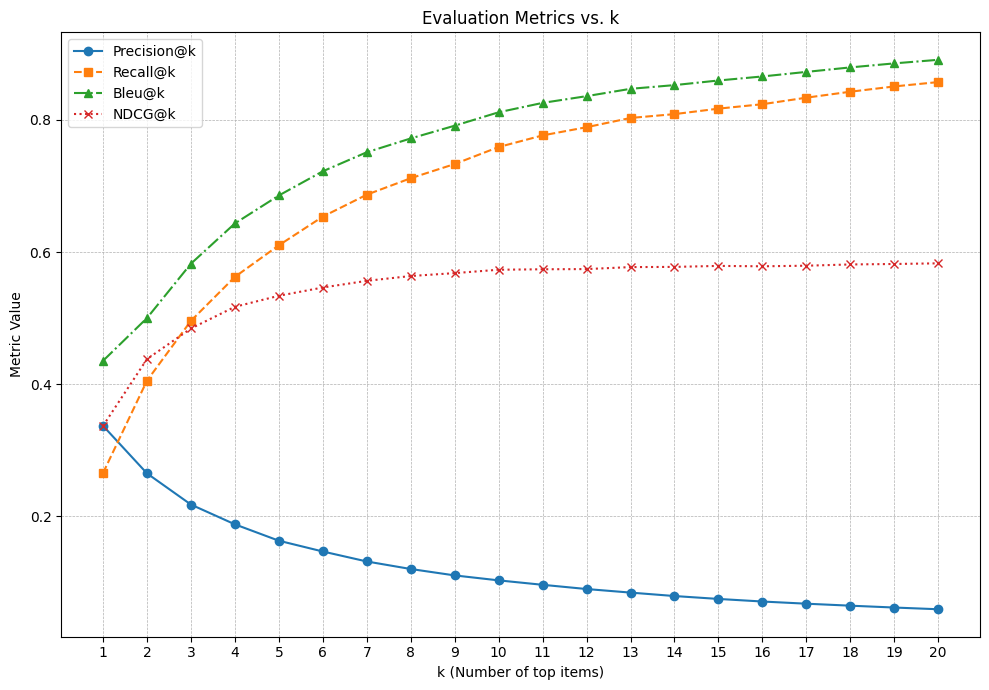

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(k_values, all_precisions, marker='o', linestyle='-', label='Precision@k')
plt.plot(k_values, all_recalls, marker='s', linestyle='--', label='Recall@k')
plt.plot(k_values, all_bleu_scores, marker='^', linestyle='-.', label='Bleu@k')
plt.plot(k_values, all_mrrs, marker='x', linestyle=':', label='NDCG@k')

plt.title('Evaluation Metrics vs. k')
plt.xlabel('k (Number of top items)')
plt.ylabel('Metric Value')
plt.xticks(k_values)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

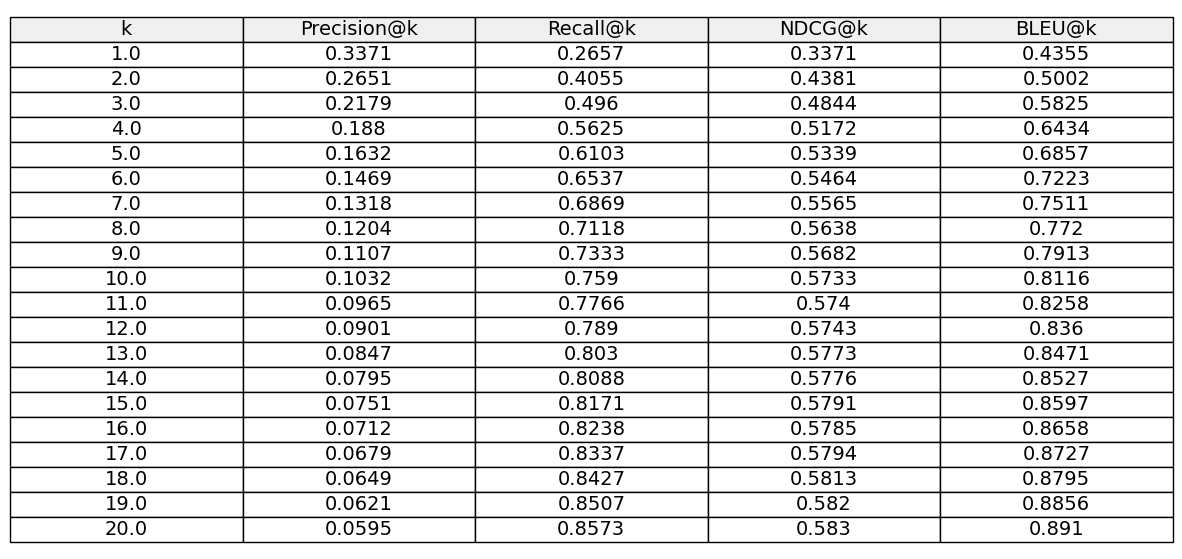

In [212]:
data = {
    'k': k_values,
    'Precision@k': all_precisions,
    'Recall@k': all_recalls,
    'NDCG@k': all_mrrs,
    'BLEU@k': all_bleu_scores
}
df = pd.DataFrame(data)
plt.figure(figsize=(10, 7))
table = plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=['#f0f0f0']*df.shape[1])
table.auto_set_font_size(False)
table.set_fontsize(14)  # Adjust font size as needed
table.scale(1.5, 1.5) 
plt.axis('off')

plt.show()

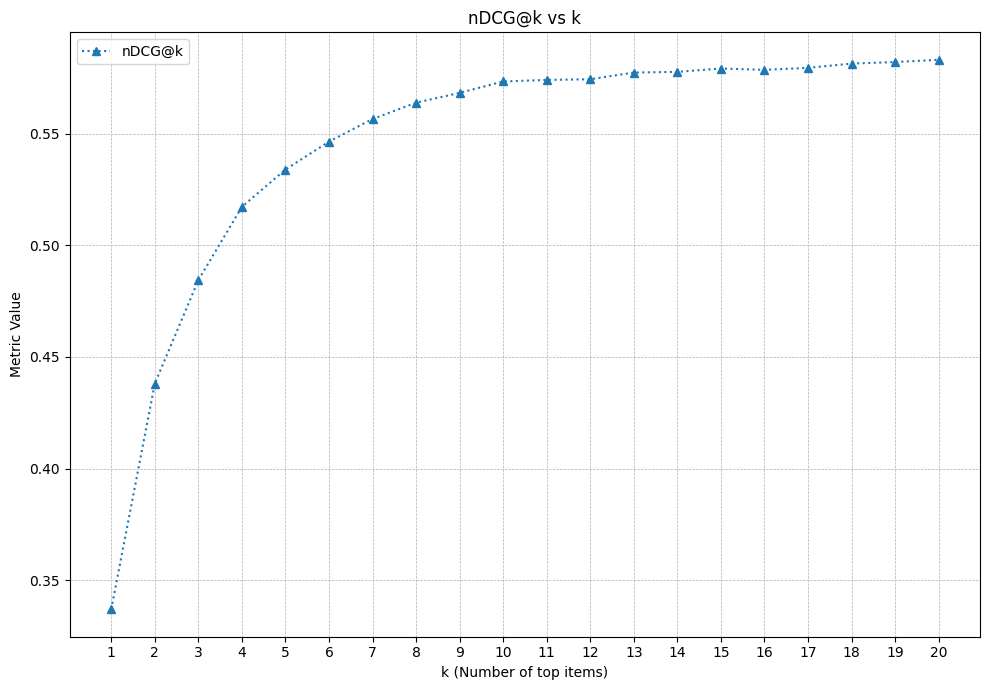

In [213]:
plt.figure(figsize=(10, 7))
plt.plot(k_values, all_mrrs, marker='^', linestyle=':', label='nDCG@k')

plt.title('nDCG@k vs k')
plt.xlabel('k (Number of top items)')
plt.ylabel('Metric Value')
plt.xticks(k_values)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()